# Week 4 - Word Embeddings Supplemental

This notebook contains two additional uses for word embeddings

For this notebook we will be using the following packages

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. 

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [4]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

FileNotFoundError: [Errno 2] No such file or directory: '../data/resumeAll.model'

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["basic", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 1a*</span>

<span style="color:red">**Do only 1a or 1b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [11]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [12]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

FileNotFoundError: File b'../data/ASCO_abstracts.csv' does not exist

Prepare for wor2vec

In [13]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

NameError: name 'ascoDF' is not defined

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [14]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

Now we generate the models

In [15]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

NameError: name 'ascoDF' is not defined

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change

In [16]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words

In [187]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

KeyError: "word 'breast' not in vocabulary"

In [18]:
targetWord = 'triple'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

NameError: name 'comparedEmbeddings' is not defined

We can also ask which words changed the most

In [19]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [20]:
wordDivergences = findMostDivergent(comparedEmbeddings)

NameError: name 'comparedEmbeddings' is not defined

The most divergent words are:

In [21]:
wordDivergences[:10]

NameError: name 'wordDivergences' is not defined

And the least

In [22]:
wordDivergences[-10:]

NameError: name 'wordDivergences' is not defined

In [23]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

NameError: name 'wordDivergences' is not defined

In [24]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

NameError: name 'wordDivergences' is not defined

## <span style="color:red">*Exercise 1b*</span>

<span style="color:red">**Do only 3a or 3b.** Construct cells immediately below this that align word embeddings over time. Interrogate the spaces that result and ask which words change most of the whole period. What does this reveal about the social game underlying your space?

In 2005, the Council of Indonesian Islamic Scholars (MUI) issued a <i>fatwa</i>, or religious opinion, that condemned the idea of pluralism, liberalism, and secularism as running counter to Islamic teachings in terms of doctrine and acts of worship. In regards to human interactions, the <i>fatwa</i> stated that in a society with religious pluralism the Muslim community should assume an exclusivist attitude and only interact with non-Muslims to the extent of not inflicting harm. However, what ‘harm’ really means was not clearly defined in the <i>fatwa</i> and is left open to interpretation. Islamic social movement organizations across the Indonesian political spectrum, such as the vigilantes of the <b>Islamic Defenders Front (FPI)</b>, regarded the fatwa as a vindication of their agendas for turning Indonesia into an Islamic state. Meanwhile, some other Islamic scholars defied MUI’s fatwa and joined a broad coalition of pro-democracy activists who supported pluralism and religious tolerance. This rift in Indonesian Islamic social and political discourse has become a test for Indonesian democracy in its consolidation phase.

For my dataset I am using <b>news articles from Jakarta Post</b>, an Indonesian newspaper. I will look at  <b> Islamic Defender Front (FPI)</b>, a vigilante group in favor of explicit Islamic agendas.

There is a lack of organizational self-documentation, thus newspapers could reveal a lot about these social movement organizations as national news coverage signals activities deemed significant. I will look at how news reporting on FPI changes over time.

**What:**<br>
Analyzing news articles between 2008 - 2018 on FPI, an Islamic social movement organization in Indonesia.

**Dataset**<br>
News articles scraped from Jakarta Post that contains the word 'FPI' (the organization of interest).

**Findings:**<br>
1) There seems to be little change in 2009 and 2015 and some change in 2009 in comparison to any other years. There are spikes in FPI activities at these times with references to 'violence'.

**Evaluation**<br>
I will have to process a larger dataset, this might take a long time to process. I am only working with a sample here.

In [228]:
news_DF = pandas.read_csv('FPI.csv', encoding='latin-1')
news_DF[690:700]

,Date,Title,Article,Link,Topics,Year
690,"Mon, May 7 2012",FPI gets tough on all foreign performers,JAKARTA: The Islamic Defenders Front (FPI) ins...,http://www.thejakartapost.com/news/2012/05/07/...,NaN,2012
691,"Tue, May 8 2012","Inaction against vigilantes, Indonesia in auto...","Almost 14 years ago, authoritarian ruler Soeha...",http://www.thejakartapost.com/news/2012/05/08/...,NaN,2012
692,"Tue, May 8 2012",Impotent govt lets FPI run rampant: Top crimin...,"The involvement of the hard-line group, the Is...",http://www.thejakartapost.com/news/2012/05/08/...,NaN,2012
693,"Tue, May 8 2012",Editorial: Freedom to silence,Contrary to everybodyÕs hopes to see the fruit...,http://www.thejakartapost.com/news/2012/05/08/...,NaN,2012
694,"Tue, May 8 2012",Issues of the day: No religion endorses homose...,"Freedom of speech: Irshad Manji, author of All...",http://www.thejakartapost.com/news/2012/05/08/...,NaN,2012
695,"Wed, May 9 2012",ÔLittle MonstersÕ growl over threats to Gaga,"The fans of American pop singer Lady Gaga, kno...",http://www.thejakartapost.com/news/2012/05/09/...,NaN,2012
696,"Wed, May 9 2012",Attacks against Irshad Manji Ñ ÔJagoismÕ at it...,Canadian Muslim author Irshad Manji has been t...,http://www.thejakartapost.com/news/2012/05/09/...,NaN,2012
697,"Wed, May 9 2012",Discussion dispersal threatens democracy,Freedom of speech was again violated when a gr...,http://www.thejakartapost.com/news/2012/05/09/...,NaN,2012
698,"Wed, May 9 2012",Issue: Activist beaten in defense of churchgoers,"May 6, Online A rights activist from the Assoc...",http://www.thejakartapost.com/news/2012/05/09/...,NaN,2012
699,"Thu, May 10 2012",Text your say : Freedom of speech at risk,Your comments on the police breaking up a disc...,http://www.thejakartapost.com/news/2012/05/10/...,NaN,2012


Prepare for Word2Vec

In [229]:
news_DF['tokenized_sents'] = news_DF['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
news_DF['normalized_sents'] = news_DF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

In [208]:
news_DF

,Date,Title,Article,Link,Topics,Year,tokenized_sents,normalized_sents
0,"Tue, December 12, 2017",Anies unaware of lunch meeting with mass organ...,Members of several mass organizations went to ...,http://www.thejakartapost.com/news/2017/12/12/...,"anies-baswedan, mass-organizations, FPI, Forkabi",2017,"[[Members, of, several, mass, organizations, w...","[[members, several, mass, organizations, went,..."
1,"Fri, December 1, 2017","Rizieq Shihab to attend 212 reunion rally, law...",Islam Defenders Front (FPI) leader Rizieq Shih...,http://www.thejakartapost.com/news/2017/12/01/...,NaN,2017,"[[Islam, Defenders, Front, (, FPI, ), leader, ...","[[islam, defenders, front, fpi, leader, rizieq..."
2,"Mon, November 27, 2017",Police to deploy personnel at Soekarno-Hatta t...,The Jakarta Police planÊtoÊinstallÊa temporary...,http://www.thejakartapost.com/news/2017/11/27/...,"Rizieq-Shihab, 212Rally, police",2017,"[[The, Jakarta, Police, planÊtoÊinstallÊa, tem...","[[jakarta, police, planêtoêinstallêa, temporar..."
3,"Sun, August 20, 2017",Anies wants FPI to improve its image,Jakarta governor-elect Anies Baswedan has call...,http://www.thejakartapost.com/news/2017/08/20/...,"anies-baswedan, FPI, Diversity, anniversary, s...",2017,"[[Jakarta, governor-elect, Anies, Baswedan, ha...","[[jakarta, anies, baswedan, called, hardline, ..."
4,"Sat, August 19, 2017",Rizieq wants to go home after being questioned...,Islam Defenders Front (FPI) leader Rizieq Shih...,http://www.thejakartapost.com/news/2017/08/19/...,"FPI, Rizieq-Shihab, pornography, police, inves...",2017,"[[Islam, Defenders, Front, (, FPI, ), leader, ...","[[islam, defenders, front, fpi, leader, rizieq..."
5,"Wed, June 7, 2017",Airport safety simulation conducted prior to R...,Police have conducted a simulation to ensureÊJ...,http://www.thejakartapost.com/news/2017/06/07/...,"Rizieq-Shihab, security, Airport",2017,"[[Police, have, conducted, a, simulation, to, ...","[[police, conducted, simulation, ensureêjakart..."
6,"Wed, June 7, 2017",Komnas HAM to investigate vigilantism by hard-...,The National Commission on Human Rights (Komna...,http://www.thejakartapost.com/news/2017/06/06/...,"Komnas-HAM, Komnas, persecution, vigilantism, ...",2017,"[[The, National, Commission, on, Human, Rights...","[[national, commission, human, rights, komnas,..."
7,"Tue, June 6, 2017",Komnas HAM supports firm police action in tack...,The National Commission on Human Rights (Komna...,http://www.thejakartapost.com/news/2017/06/06/...,"Komnas, Komnas-HAM, vigilantism, National-Poli...",2017,"[[The, National, Commission, on, Human, Rights...","[[national, commission, human, rights, komnas,..."
8,"Tue, June 6, 2017",Lawyers support police's fight against radical...,A group of lawyers attached toÊthe Pancasila D...,http://www.thejakartapost.com/news/2017/06/06/...,"radicalism, intolerance, FPI, Islam-Defenders-...",2017,"[[A, group, of, lawyers, attached, toÊthe, Pan...","[[group, lawyers, attached, toêthe, pancasila,..."
9,"Tue, June 6, 2017",MUI issues how-to guide to make social media g...,With social media increasingly turning into a ...,http://www.thejakartapost.com/news/2017/06/06/...,"social-media, MUI, Muslims, Rizieq-Shihab, Com...",2017,"[[With, social, media, increasingly, turning, ...","[[social, media, increasingly, turning, platfo..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [214]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

Now we generate the models.

In [215]:
rawEmbeddings, comparedEmbeddings = compareModels(news_DF, 'Year')

We need to compare them across all permutations so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [216]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Let's look at a couple of words.

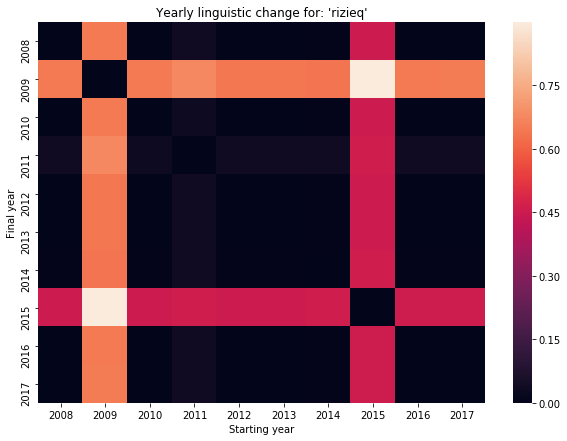

In [219]:
targetWord = 'rizieq'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

As the scale goes from 0 to 2 to measure relative change over time, there has been little change in the word's use over time as shown by little variation of shades in the heatmap.

Rizieq is FPI's leader, it seems like there is little change in how he is mentioned over time as shown by the black shade across the heatmap. However, in 2009 and 2015 there seems to be little change and some change in 2009 in comparison to any other years.

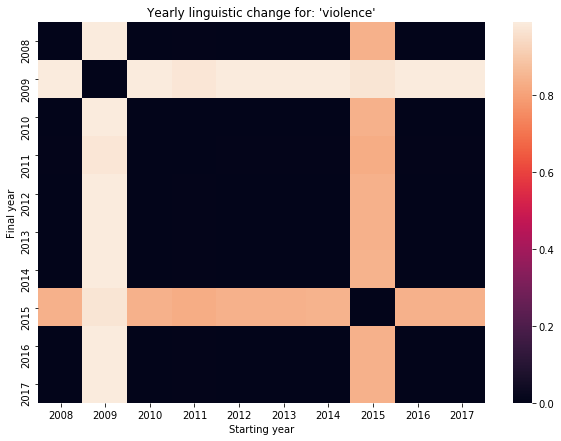

In [218]:
targetWord = 'violence'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

As the scale goes from 0 to 2 to measure relative change over time, there has been little change in the word's use over time as shown by little variation of shades in the heatmap.

Similar to 'Rizieq' in the previous analysis, it seems like there is little change in how violence is mentioned over time as shown by the black shade across the heatmap. However, in 2009 there seems to be little change in 2015 and some change in 2009 in comparison to any other years. This is possibly because Rizieq and violence are related to each other, which is expected as FPI tends to be violent in their political actions.

We can also look at which words changed the most.

In [220]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [221]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 71 words to compare


The most divergent words are:

In [222]:
wordDivergences[:10]

[('report', 2.0938904359936714),
 ('country', 1.8375186994671822),
 ('violence', 1.8353915885090828),
 ('comr', 1.8311123251914978),
 ('friday', 1.7420735098421574),
 ('post', 1.662220299243927),
 ('chief', 1.6569644659757614),
 ('security', 1.6486937254667282),
 ('involved', 1.6459396928548813),
 ('take', 1.6306933164596558)]

And the least:

In [223]:
wordDivergences[-10:]

[('west', 1.1558827459812164),
 ('rizieq', 1.1421388983726501),
 ('political', 1.1392018496990204),
 ('groups', 1.090252697467804),
 ('members', 1.0802621841430664),
 ('said', 1.0686436891555786),
 ('would', 1.0571327209472656),
 ('year', 1.0555293262004852),
 ('fpi', 0.9984140694141388),
 ('council', 0.9791470766067505)]

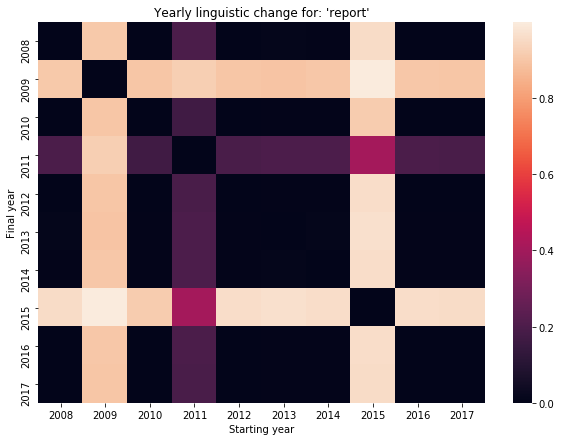

In [224]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

Interestingly the word report changes the most, which is interesting because it's quite a neutral word. However, the word aligned in 2009 and 2015 where 'Rizieq' and 'violence' changed a lot as well, denoted by a brighter colour that indicates some change.

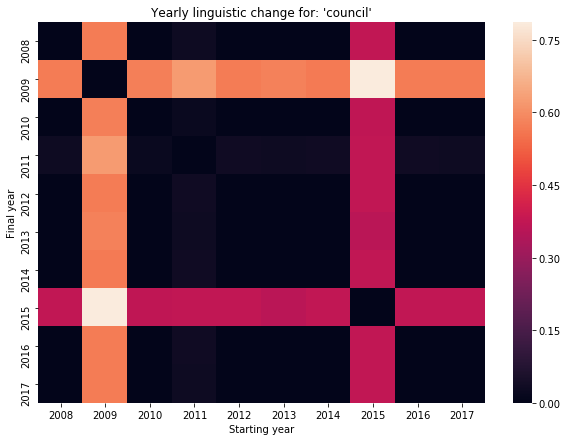

In [225]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

Finally, the word council changes less throughout the time with the word showing some changes in 2009 and 2015.